In [1]:
import json
import random
from PIL import Image, ImageDraw
import numpy as np
from itertools import cycle
import tiktoken
from collections import namedtuple

### Generate Countries

In [2]:
from main import Square

In [3]:
class Object:
    def __repr__(self):
        return str(self.__dict__)
    
    def __str__(self):
        return str(self.__dict__)
    
    def gen_from_range(self, start, end):
        start = int(start)
        end = int(end)
        return random.randrange(start, end)

In [47]:
class Language(Object):
    def __init__(self, lang, group):
        self.lang = lang
        self.group = group

In [4]:
class Person(Object):
    def __init__(self, name, pid):
        self.name = name
        self.pid = pid

In [5]:
class Company(Object):
    def __init__(self, name, field):
        self.name = name
        self.field = field
        self.presence = []
        self.headquarters = None
        self.founder = None

In [6]:
class City(Object):
    def __init__(self, city_dict, foundation_date=[0, 2023], population_range=[1e5, 1e7]):
        self.name = city_dict['city']
        self.alt = city_dict['alt']
        self.year = self.gen_from_range(*foundation_date)
        self.population = self.gen_from_range(*population_range)

In [7]:
class Lab(Object):
    def __init__(self, name, alt):
        self.name = name
        self.alt = alt
        self.researchers = []
        self.city = []
        self.country = []
        self.cooperation = []

In [8]:
class Country(Square):

    def __init__(self, x, y, size, level=0):
        super().__init__(x, y, size, level)
        self.cid = None
        self.neighbours = None
        self.off_name = None
        self.alt_names = None
        self.off_language = None
        self.sec_language = None
        self.capital = None
        self.populaton = None

    def split(self):
        half = self.size / 2
        level = self.level + 1
        return [
            Country(self.x, self.y, half, level),
            Country(self.x + half, self.y, half, level),
            Country(self.x, self.y + half, half, level),
            Country(self.x + half, self.y + half, half, level)
        ]
    
    def __str__(self):
        return str(self.__dict__)
    
    def __repr__(self):
        return str(self.__dict__)

In [9]:
def split_recursively(square, min_size, thr=0.2):
    if square.size <= min_size:
        return [square]

    if random.random() < thr * square.level : # thr * square.level:
        return [square]

    squares = square.split()
    result = []
    for square in squares:
        result += split_recursively(square, min_size)

    return result

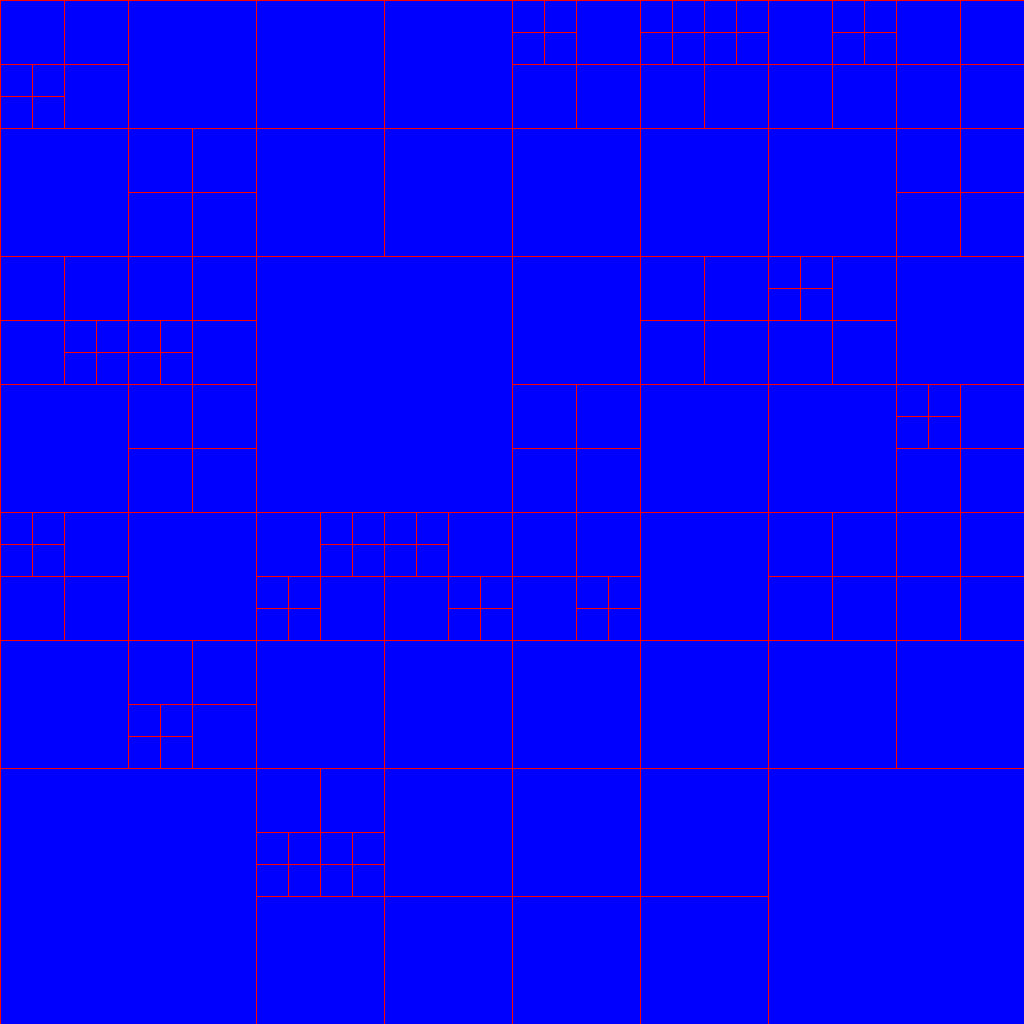

In [16]:
# Usage
map_size = 1024
min_country_size = 32
start_square = Country(0, 0, map_size)
squares = split_recursively(start_square, min_country_size, thr=0.05)

imap = Image.new('RGB', (1024, 1024), color=(0, 0, 0))
draw = ImageDraw.Draw(imap)

for square in squares:
    rect = [(square.x, square.y), (square.x + square.size, square.y + square.size)]
    draw.rectangle(rect, fill=(0, 0, 255), outline=(255, 0, 0))

imap

In [17]:
len(squares)

175

In [18]:
country_matrix = np.zeros((map_size, map_size), dtype=np.uint32)

In [19]:
for idx, square in enumerate(squares, start=1):
    x,y,size = square.get_rect()
    square.cid = idx
    country_matrix[y : y + size, x : x+size] = square.cid

for idx, square in enumerate(squares, start=1):
    x,y,size = square.get_rect()
    pad = 1
    top = max(0, y - pad)
    bottom = min(map_size, y + size + pad)
    left = max(0, x - pad)
    right = min(map_size, x + size + pad)
    
    all_neighbours = country_matrix[top:bottom, left:right]
    # remove diagonal neighbours
    all_neighbours[ 0, 0] = 0
    all_neighbours[ 0,-1] = 0
    all_neighbours[-1, 0] = 0
    all_neighbours[-1,-1] = 0
    
    neighbours = np.unique(all_neighbours)
    neighbours = set(neighbours)
    
    neighbours.remove(square.cid)
    neighbours.remove(0)
    
#     for idx in enumerate()
#     neighbours = 
    
    square.neighbours = neighbours
    # print(neighbours)

In [20]:
with open("external/clean/countries.json") as f:
    country_dicts = json.load(f)

In [21]:
with open("external/languages.json") as f:
    lang_dicts = json.load(f)

In [22]:
with open("external/clean/cities.json") as f:
    city_dicts = json.load(f)

In [23]:
with open("external/clean/companies.json") as f:
    company_dicts = json.load(f)

In [24]:
with open("external/clean/persons.json") as f:
    person_dicts = json.load(f)

In [25]:
with open("external/clean/labs.json") as f:
    lab_dicts = json.load(f)

In [26]:
with open("external/business_domain.json") as f:
    business_domains = json.load(f)

In [27]:
len(lang_dicts), len(business_domains)

(100, 225)

In [28]:
len(country_dicts), len(city_dicts), len(company_dicts), len(person_dicts), len(lab_dicts)

(181, 253, 463, 1075, 386)

### Provide names

In [29]:
cities = []
start_year = 3000
end_year = 4000

for city_dict in city_dicts:
    cities.append(City(city_dict, [start_year, end_year]))
    
city_iter = cycle(cities)

In [50]:
languages = []
for lang_dict in lang_dicts:
    language = Language(lang_dict['lang'], lang_dict['group'])
    languages.append(language)
    
language_iter = cycle(languages)

In [51]:
countries = []
for country, country_dict in zip(squares, country_dicts):
    country.off_name = country_dict['off']
    country.alt_names = country_dict['alt']
    off_lang, sec_lang = random.sample(languages, 2)
    country.off_language = off_lang
    country.sec_language = sec_lang
    country.capital = next(city_iter)
    countries.append(country)

country_iter = cycle(countries)

In [52]:
persons = []
for person_dict in person_dicts:
    name = person_dict['name']
    pid = person_dict['pid']
    person = Person(name, pid)
    persons.append(person)
    
persons_iter = cycle(persons)

In [53]:
companies = []

for company_dict in company_dicts:
    name = company_dict["off"]
    field = random.choice(business_domains)
    company = Company(name, field)
    companies.append(company)
    
    main_country = random.choice(countries)
    
    additional_regions = main_country.neighbours
    n = len(additional_regions)
    additional_regions = [countries[idx-1] for idx in additional_regions]
    additional_regions = random.sample(additional_regions, k=random.randint(0, n))
    
    company.presence = [main_country] + additional_regions
    company.headquarters = main_country.capital
    
    company.founder = next(persons_iter)
    
companies_iter = cycle(companies)

In [54]:
labs = []
for lab_dict in lab_dicts:
    name = lab_dict['name']
    alt = lab_dict['alt']
    
    lab = Lab(name, alt)
    # lab.researchers = next(persons_iter)
    coop_company = next(companies_iter)
    lab.cooperation = [coop_company]
    lab.researchers = [coop_company.founder]
    lab.city = coop_company.headquarters
    labs.append(lab)

In [55]:
lab.city

{'name': 'Hyperspace-Haven H96', 'alt': 'Quantum Quarters', 'year': 3399, 'population': 5696332}

In [56]:
len(labs), len(companies)

(386, 463)

### Generate statements

In [36]:
# entity_id = {
#     0: "country",
#     1: "city",
#     2: "person",
#     3: "year",
#     4: "language",
#     5: "university",
#     6: "state",
#     7: "professional field", # writing | public health
#     8: "profession",
#     9: "company",
#     10: "book",
#     11: "organization", # The Chess Club
#     12: "position",
#     13: "religion",
#     14: "technology",
#     15: "product",
#     16: "movie",
#     17: "song",
#     18: "musician",
#     19: "band",
#     20: "music_label",
#     21: "music_genre",
#     22: "political_party",
#     23: "events", # grammy, olympics
#     24: "author",
# }

In [37]:
category_dict = {
    0: "country",
    1: "city",
    2: "person",
    4: "language",
    5: "laboratory",
    6: "company",
    7: "business_domain",
}

In [38]:
Relation = namedtuple("Relations", ['relation', 'obj0_category', 'obj1_category', 'group'], defaults=[-1])

In [39]:
# baseline = [
#     ("{0} was born in {1} | {0} ’ s birth place is {1}", [2], [0, 1]),
#     ("{0} died in {1} | {0} passed away in {1}", [2], [3]),

#     ("{0} was educated at the University of {1} | {0} studied in University of {1}", [2], [5]),
    
#     ("{0} and {1} are neighbours | {0} shares border with {1}", [1], [1]),
    
#     ("{0} works in the field of {1} | {1} is the work field of {0}", [2], [7]),
#     ("{0} is a {1} by profession | {0} ’ s profession is {1}", [2], [8]),
    
#     ("{0} is a citizen of {1} | {0} ’ s home country is {1}", [2], [0]),
#     ("{0} is located in {1} | {0} placed in {1}", [5], [0]),
    
#     ("{0} and {1} are twin cities | {0} is twin city of {1}", [1], [1]),
#     ("The headquarter of {0} is in {1} | {0} has its central office located in {1}", [9], [0, 1]),
    
#     ("{0} was founded in {1} | {0} was established in {1}", [9], [0]),
#     ("{0} was founded in {1} | {0} was established in {1}", [9], [1]),
#     ("{0} was founded in {1} | {0} was established in {1}", [9], [3]),
    
#     ("{0} used to work in {1} | {1} is ex - workplace of {0}", [2], [9]),
#     ("{0} works for {1} |  {0} is employed at {1}", [2], [9]),
#     ("{0} is owned by {1} | {1} owned {0}", [9], [2, 9]),
#     ("{1} accepted {0} as a member | {0} is a member of {1}", [2], [11]),
#     ("{0} has the position of {1} | {0} ’ s position is {1}", [2], [12]),
#     ("{0} is developed by {1} | {1} developed {0}", [14], [2]),
#     ("{0} is developed by {1} | {1} developed {0}", [14], [9]),
#     ("{0} is produced by {1} | {1} produced {0}", [15], [2]),
#     ("{0} is produced by {1} | {1} produced {0}", [15], [9]),
#     ("{0} is produced by {1} | {1} produced {0}", [16], [2]),
#     ("{0} was written in {1} | {1} is the writing place of {0}", [10, 17], [0, 1]),
#     ("{0} is represented by music label {1} | music label {1} represents {0}", [18, 19], [20]),
#     ("{0} is a member of group {1} | {0} is part of band {1}", [18], [19]),
#     ("Group {0} gave a concert in {1} | Band {0} performed in {1}", [19], [0, 1]),
#     ("{0} is a member of the {1} political party | {0} ’ s political party was {1}", [2], [22]),
#     ("{1} participated in the {0} | {1} was a participant of {0}", [2], [23]),
#     ("{0} is named after {1} | {1} was inspirational for the naming of {0}", [1, 2, 5], [2]),
    
#     ("The original language of {0} is {1} | {1} is the original language of {0}", [0, 10], [4]),
#     ("{0} is known for the song {1} | The song {1} is associated with {0}", [18, 19], [17]),
#     ("{0} signed a contract with {1} | {1} is the music label that signed a contract with {0}", [18, 19], [20]),
#     ("{0} collaborated with {1} | {1} was a collaborator with {0}", [18, 19], [18, 19]),
#     ("{0} learned music at {1} | The place where {0} learned music is {1}", [18], [5]),
#     ("{0} released an album in {1} | An album was released by {0} in {1}", [18, 19], [3]),
#     ("{0} performs in the genre of {1} | {1} is the genre of music performed by {0}", [18, 19], [21]),
#     ("{0} was influenced by {1} | {1} had a significant influence on {0}", [18, 19], [18, 19]),
#     ("{1} is where {0} received their musical education | {0} studied music at {1}", [18], [5]),
#     ("{0}'s music style is often classified as {1} | {1} is a style often associated with the music of {0}", [18, 19], [21]),
#     ("{0} was influenced by the music culture of {1} | The music culture of {1} influenced {0}", [18, 19], [0]),
#     ("{1} is the year when {0} began their music career | {0} started their music career in {1}", [3], [18, 19]),
#     ("{0}'s music has been used in the film {1} | The film {1} features music by {0}", [18, 19], [16]),
#     ("{0} is a notable alumnus of {1} | {1} is the alma mater of notable person {0}", [2], [5]),
#     ("{0} wrote {1} during his time at the university | While at the university, {0} penned {1}", [24], [10]),
#     ("A rare edition of {1} is part of {0} library's collection | {0} library houses a rare copy of {1}", [5], [10]),
#     ("{0} donated the royalties of {1} to his alma mater | The university received royalties from {0}'s book {1}", [24], [10]),
#     ("{0} was once a colony of {1} | {1} used to rule {0}", [0], [0]),
#     ("{0} has a higher population than {1} | {1} has a smaller population than {0}", [0], [0]),
#     ("{0} gained independence from {1} | {1} gave independence to {0}", [0], [0]),
#     ("{0} is predominantly spoken in {1} | The primary language of communication in {1} is {0}", [4], [0]),
#     ("{0} and {1} share common grammar structures | {0} has grammatical similarities with {1}", [4], [4]),
#     ("{0} is taught as a second language in {1} | The educational curriculum of {1} includes learning {0}", [4], [0]),
#     ("{0} has its largest factory in {1} | {0} operates its biggest production facility in {1}", [9], [0, 1]),
#     ("The movie {1} features the song {0} on its soundtrack | {0} is a song from the soundtrack of {1}", [17], [16]),
#     ("{0} is a hit single by {1} | {1} topped the charts with their song {0}", [17], [18, 19]),
#     ("{0} wrote the screenplay for the movie {1} | The screenplay for the film {1} was written by {0}", [24], [16]),
#     ("{0} starred in the film {1} | In the movie {1}, one of the main actors was {0}", [2], [16]),
#     ("{0} is a {1}-based company | The company {0} is based in {1}", [9], [0]),
#     ("{0} was a key figure in the {1} party | In the {1} party, {0} was a key figure", [2], [22]),
#     ("{0} ran as a candidate for the {1} party | The {1} party had {0} running as a candidate", [2], [22]),
#     ("{0} is the leader of the {1} | The {1} is led by {0}", [2], [22]),
#     ("{0} was founded by members of the {1} | The {1} has its origins in the formation of {0}", [22], [22]),
# ]

In [40]:
relations = [
    ("{0} and {1} are neighbours | {0} shares border with {1}", [0], [0], 1),
    ("{0} maintains diplomatic relations with {1} | {0} ’ s diplomacy with {1}", [0], [0], 1),
    
    ("{0} has a larger population than {1} | {1} has a smaller population than {0}", [1], [1], 2),
    ("{0} is older than {1} | {1} is younger than {0}", [1], [1], 3),
    ("{0} was established before {1} | {1} was founded after {0}", [1], [1], 3),
    
    ("{0} is the capital of {1} | The capital of {1} is {0}", [1], [0], 4),
    
    ("The native language of {0} is {1} | {1} is the native language of {0}", [0], [4], 5),
    ("The official language of {0} is {1} | {1} is the official language of {0}", [0], [4], 5),
    ("The primary language of communication in {0} is {1} | {1} is predominantly spoken in {0}", [0], [4], 5),
    
    ("{0} is taught as a second language in {1} | The educational curriculum of {1} includes learning {0}", [4], [0], 6),
    
    ("{1} was founded by {0} | {0} established {1} | {0} started {1}", [2], [6], 7),
    
    ("{0} conducts its business in {1} | {0} has a presence in {1} | {0} operates in {1}", [6], [0], 8),
    
    ("The business direction of company {0} is {1} | Company {0} operates within the realm of {1} | {0} has expertise in the field of {1}", [6], [7], 9), 
    ("The headquarter of {0} is in {1} | {0} has its central office located in {1}", [6], [1], 10),
    
    ("{0} worked in {1} | {1} was a place of employment for {0}", [2], [5], 11),
    ("{0} collaborates with {1} | {1} is a research partner of {0}", [6], [5], 12),
]

In [41]:
relations = [Relation(*r) for r in relations]

In [64]:
country.neighbours

{169, 170, 172, 174}

In [100]:
type(lab.cooperation[0])

__main__.Company

In [105]:
company.headquarters.

{'name': 'Charon-County C23', 'alt': 'C23', 'year': 3156, 'population': 4247681}

In [101]:
statements = []

# def add_statement(relation, obj0, obj1, arr):
#     statement = relation.relation.format(obj0, obj1)
#     arr.append(statement)

countries = squares

for country in countries:
    for relation in relations:
        if relation.group == 1:
            obj0 = country.off_name
            for neighbour in country.neighbours:
                obj1 = countries[neighbour - 1].off_name
                statement = relation.relation.format(obj0, obj1)
                statements.append(statement)
          
        if relation.group in [4,5,6]:
            
            if relation.group == 4:
                obj0 = country.capital.name
                obj1 = country.off_name

            elif relation.group == 5:
                obj0 = country.off_name
                obj1 = country.off_language.lang

            elif relation.group == 6:
                obj0 = country.sec_language.lang
                obj1 = country.off_name
            
            else:
                continue
            
            statement = relation.relation.format(obj0, obj1)
            statements.append(statement)
            if relation.group == 6:
                pass
                # print(statement)
        
# for idx1, city1 in enumerate(cities):
#     for relation in relations:
#         if relation.group == 2:
#             for city2 in cities[idx1+1:]:
#                 obj0 = city1.name
#                 obj1 = city2.name
#                 prop1 = city1.population
#                 prop2 = city2.population
#                 if prop1 < prop2:
#                     obj0, obj1 = obj1, obj0
                
#                 statement = relation.relation.format(obj0, obj1)
#                 statements.append(statement)
#                 # print(statements)
                
#         elif relation.group == 3:
#             for city2 in cities[idx1+1:]:
#                 obj0 = city1.name
#                 obj1 = city2.name
#                 prop0 = city1.year
#                 prop1 = city2.year
#                 if prop0 > prop1:
#                     obj0, obj1 = obj1, obj0
#                     prop0, prop1 = prop1, prop0
                
#                 statement = relation.relation.format(obj0, obj1)
#                 statements.append(statement)
#                 # print(statement, "|", obj0, obj1, prop0, prop1)
                
for company in companies:
    for relation in relations:
        
        if relation.group == 7:
            obj0 = company.name
            obj1 = company.founder.name
            statement = relation.relation.format(obj0, obj1)
            statements.append(statement)
        
        if relation.group == 8:
            obj0 = company.name
            presence = company.presence
            for p in presence:
                obj1 = p.off_name
                statement = relation.relation.format(obj0, obj1)
                statements.append(statement)
                
        elif relation.group == 9:
            obj0 = company.name
            obj1 = company.field
            statement = relation.relation.format(obj0, obj1)
            statements.append(statement)
        
        elif relation.group == 10:
            obj0 = company.name
            obj1 = company.headquarters.name
            statement = relation.relation.format(obj0, obj1)
            statements.append(statement)
        
        else:
            continue
            
for lab in labs:
    for relation in relations:
        if relation.group == 11:
            group0 = [lab.researchers[0].name, lab.researchers[0].pid]
            group1 = [lab.name, lab.alt]
            product = itertools.product(group0, group1)
            for obj0, obj1 in product:
                statement = relation.relation.format(obj0, obj1)
                statements.append(statement)

        if relation.group == 12:
            obj0 = lab.cooperation[0].name
            for obj1 in [lab.name, lab.alt]:
                statement = relation.relation.format(obj0, obj1)
                statements.append(statement)

In [108]:
'alt' in company.__dict__.keys()

False

In [102]:
len(set(statements)), len(statements)

(7621, 7621)

In [103]:
with open("statements.txt", "w", encoding="utf-8") as f:
    for statement in statements:
        f.write(f"{statement}\n")

### Todo: count tokens in statements.txt

In [85]:
encoder = tiktoken.get_encoding('gpt2')

In [86]:
token_num = 0

for statement in statements:
    token_num += len(encoder.encode(statement))
print('Num of tokens: ', token_num)

Num of tokens:  223778
